In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import diags
import time
import scienceplots
import pandas as pd

plt.style.use(["science", "no-latex"])
plt.rcParams.update(
    {
        "font.size": 14
        # "font.family": "serif",
        # "font.serif": ["Source Han Serif SC VF"],
    }
)

In [2]:
np.set_printoptions(linewidth=200)

In [3]:
def zg(a, b, c, d):
    n = len(b) - 1  # Adjust for 0-based indexing
    u = np.zeros(n + 1)
    l = np.zeros(n + 1)
    x = np.zeros(n + 1)
    y = np.zeros(n + 1)

    # Initialize the first element
    if b[0] == 0:
        raise ValueError("Matrix is singular.")

    u[0] = b[0]

    # Forward elimination
    for k in range(1, n + 1):
        if u[k - 1] == 0:
            raise ValueError("Matrix is singular.")
        l[k] = a[k] / u[k - 1]
        u[k] = b[k] - l[k] * c[k - 1]  # Update u[k] based on l[k]

    # Back substitution
    y[0] = d[0]

    for k in range(1, n + 1):
        y[k] = d[k] - l[k] * y[k - 1]

    if u[n] == 0:
        raise ValueError("Matrix is singular.")

    x[n] = y[n] / u[n]
    for k in range(n - 1, -1, -1):
        x[k] = (y[k] - c[k] * x[k + 1]) / u[k]

    return x

In [4]:
def J(n=9, max_iter=1000, tol=1e-5):
    u = np.zeros([n + 2, n + 2])
    h = 1 / (n + 1)
    f = np.full([n + 2, n + 2], h**2 * 2)
    for k in range(max_iter):
        e = 0.0
        uo = u.copy()  # 存储上一个迭代步数的解
        for j in range(1, n + 1):
            for i in range(1, n + 1):
                uol = u[i, j].copy()
                u[i, j] = (
                    uo[i - 1, j] + u[i + 1, j] + uo[i, j - 1] + u[i, j + 1] + f[i, j]
                ) / 4
                e = e + np.abs(u[i, j] - uol)
        if e / n**2 < tol:
            break
    # print(f"Jacobi迭代次数为：{k+1}")
    return u, k + 1

In [5]:
def GS(n=9, max_iter=1000, tol=1e-5):
    u = np.zeros([n + 2, n + 2])
    h = 1 / (n + 1)
    f = np.full([n + 2, n + 2], h**2 * 2)
    for k in range(max_iter):
        e = 0.0
        for j in range(1, n + 1):
            for i in range(1, n + 1):
                uo = u[i, j].copy()
                u[i, j] = (
                    u[i - 1, j] + u[i + 1, j] + u[i, j - 1] + u[i, j + 1] + f[i, j]
                ) / 4
                e = e + np.abs(u[i, j] - uo)
        if e / n**2 < tol:
            break
    # print(f"G-S迭代次数为：{k+1}")
    return u, k + 1

In [6]:
def SOR(n=9, max_iter=1000, tol=1e-5, w=1.55):
    u = np.zeros([n + 2, n + 2])
    h = 1 / (n + 1)
    f = np.full([n + 2, n + 2], h**2 * 2)
    for k in range(max_iter):
        e = 0.0
        for j in range(1, n + 1):
            for i in range(1, n + 1):
                uo = u[i, j].copy()
                u[i, j] = (
                    (
                        (4 / w - 4) * u[i, j]
                        + u[i - 1, j]
                        + u[i + 1, j]
                        + u[i, j - 1]
                        + u[i, j + 1]
                        + f[i, j]
                    )
                    * w
                    / 4
                )
                e = e + np.abs(u[i, j] - uo)
        if e / n**2 < tol:
            break
    # print(f"SOR迭代次数为：{k+1}")
    return u, k + 1

In [7]:
def SSOR(n=9, max_iter=1000, tol=1e-5, w=1.55):
    u = np.zeros([n + 2, n + 2])
    um = np.zeros([n + 2, n + 2])
    h = 1 / (n + 1)
    f = np.full([n + 2, n + 2], h**2 * 2)
    for k in range(max_iter):
        e1 = 0.0
        e2 = 0.0
        for j in range(1, n + 1):
            for i in range(1, n + 1):
                uo = um[i, j].copy()
                um[i, j] = (
                    (
                        (4 / w - 4) * um[i, j]
                        + um[i - 1, j]
                        + um[i + 1, j]
                        + um[i, j - 1]
                        + um[i, j + 1]
                        + f[i, j]
                    )
                    * w
                    / 4
                )
                e1 = e1 + np.abs(um[i, j] - uo)
        for j in range(n, 0, -1):
            for i in range(n, 0, -1):
                uo1 = um[i, j].copy()
                u[i, j] = (
                    (
                        (4 / w - 4) * um[i, j]
                        + um[i - 1, j]
                        + u[i + 1, j]
                        + um[i, j - 1]
                        + u[i, j + 1]
                        + f[i, j]
                    )
                    * w
                    / 4
                )
                e2 = e2 + np.abs(u[i, j] - uo1)
        if (e1 + e2) / n**2 < tol:
            break
    # print(f"SSOR迭代次数为：{k+1}")
    return u, k + 1

In [8]:
def BJ(n=9, max_iter=1000, tol=1e-5):
    u = np.zeros([n + 2, n + 2])
    h = 1 / (n + 1)
    f = np.full([n + 2, n + 2], h**2 * 2)
    a = -1 * np.ones(n)
    b = 4 * np.ones(n)
    c = -1 * np.ones(n)
    d = np.zeros(n)
    for k in range(max_iter):
        e = 0.0
        u_old = u.copy()
        for j in range(1, n + 1):
            u_o_n = u[:, j].copy()
            d = f[1 : n + 1, j] + u_old[1 : n + 1, j - 1] + u[1 : n + 1, j + 1]
            x = zg(a, b, c, d)
            u[1 : n + 1, j] = x
            e = e + np.linalg.norm(u_o_n - u[:, j], 1)
        if e / n**2 < tol:
            break
    # print(f"块Jacobi方法迭代次数：{k+1}")
    return u, k + 1

In [9]:
def BGS(n=9, max_iter=1000, tol=1e-5):
    u = np.zeros([n + 2, n + 2])
    h = 1 / (n + 1)
    f = np.zeros([n + 2, n + 2])
    f[1 : n + 1, 1 : n + 1] = h**2 * 2  # 仅内部节点赋值
    a = -1 * np.ones(n)
    b = 4 * np.ones(n)
    c = -1 * np.ones(n)
    d = np.zeros(n)
    for k in range(max_iter):
        e = 0.0
        for j in range(1, n + 1):
            u_old = u[:, j].copy()
            d = f[1 : n + 1, j] + u[1 : n + 1, j - 1] + u[1 : n + 1, j + 1]
            x = zg(a, b, c, d)
            u[1 : n + 1, j] = x
            e = e + np.linalg.norm(u_old - u[:, j], 1)
        if e / n**2 < tol:
            break
    # print(f"块Gauss-Seider方法迭代次数：{k+1}")
    return u, k + 1

In [10]:
def BSOR(n=9, max_iter=1000, tol=1e-5, w=1.43):
    u = np.zeros([n + 2, n + 2])
    h = 1 / (n + 1)
    f = np.zeros([n + 2, n + 2])
    f[1 : n + 1, 1 : n + 1] = h**2 * 2  # 仅内部节点赋值
    a = -1 * np.ones(n)
    b = 4 * np.ones(n)
    c = -1 * np.ones(n)
    d = np.zeros(n)
    for k in range(max_iter):
        e = 0.0
        for j in range(1, n + 1):
            u_old = u[:, j].copy()
            d = f[1 : n + 1, j] + u[1 : n + 1, j - 1] + u[1 : n + 1, j + 1]
            x = zg(a, b, c, d)
            u[1 : n + 1, j] = w * x + (1 - w) * u_old[1 : n + 1]
            e = e + np.linalg.norm(u_old - u[:, j], 1)
        if e / n**2 < tol:
            break
    # print(f"块SOR方法迭代次数：{k+1}")
    return u, k + 1

In [11]:
def BSSOR(n=9, max_iter=1000, tol=1e-5, w=1.43):
    u = np.zeros([n + 2, n + 2])
    um = np.zeros([n + 2, n + 2])
    h = 1 / (n + 1)
    f = np.zeros([n + 2, n + 2])
    f[1 : n + 1, 1 : n + 1] = h**2 * 2  # 仅内部节点赋值
    a = -1 * np.ones(n)
    b = 4 * np.ones(n)
    c = -1 * np.ones(n)
    for k in range(max_iter):
        e1 = 0.0
        e2 = 0.0
        for j in range(1, n + 1):
            u_old = um[:, j].copy()
            d1 = f[1 : n + 1, j] + um[1 : n + 1, j - 1] + um[1 : n + 1, j + 1]
            x = zg(a, b, c, d1)
            um[1 : n + 1, j] = w * x + (1 - w) * u_old[1 : n + 1]
            e1 = e1 + np.linalg.norm(u_old - um[:, j], 1)
        for j in range(n, 0, -1):
            um_old = um[:, j].copy()
            d2 = f[1 : n + 1, j] + um[1 : n + 1, j - 1] + u[1 : n + 1, j + 1]
            x2 = zg(a, b, c, d2)
            u[1 : n + 1, j] = w * x2 + (1 - w) * um_old[1 : n + 1]
            e2 = e2 + np.linalg.norm(um_old - u[:, j], 1)

        if (e1 + e2) / n**2 < tol:
            break
    # print(f"块SSOR方法迭代次数：{k+1}")
    return u, k + 1

In [12]:
def GD(n=9, max_iter=1000, tol=1e-5):
    u = np.zeros([n + 2, n + 2])
    h = 1 / (n + 1)
    f = np.full([n + 2, n + 2], h**2 * 2)

    u[0, :] = 0
    u[-1, :] = 0
    u[:, 0] = 0
    u[:, -1] = 0
    for k in range(max_iter):
        r = np.zeros([n + 2, n + 2])

        # 计算残差
        for j in range(1, n + 1):
            for i in range(1, n + 1):
                r[i, j] = f[i, j] - (
                    4 * u[i, j] - u[i - 1, j] - u[i + 1, j] - u[i, j - 1] - u[i, j + 1]
                )

        # 计算步长 alpha
        alpha_k = np.sum(r**2) / np.sum(
            4 * r[1:-1, 1:-1] ** 2
            - r[1:-1, :-2] * r[1:-1, 1:-1]
            - r[1:-1, 2:] * r[1:-1, 1:-1]
            - r[:-2, 1:-1] * r[1:-1, 1:-1]
            - r[2:, 1:-1] * r[1:-1, 1:-1]
        )

        e = 0.0
        # 更新解 u
        for j in range(1, n + 1):
            for i in range(1, n + 1):
                uo = u[i, j].copy()
                u[i, j] = u[i, j] + alpha_k * r[i, j]
                e = e + np.abs(u[i, j] - uo)

        # 检查收敛性
        # if np.linalg.norm(u - u_old) / n**2 < tol:
        if e / n**2 < tol:
            break

    # print(f"最速下降法迭代次数为：{k+1}")
    return u, k + 1

In [13]:
def CG(n=9, max_iter=1000, tol=1e-5):
    # 初始化
    u = np.zeros([n + 2, n + 2])  # 解的网格 (包括边界)
    h = 1 / (n + 1)
    f = np.full([n + 2, n + 2], h**2 * 2)
    # 设置边界条件 (假设为零)
    u[0, :] = 0
    u[-1, :] = 0
    u[:, 0] = 0
    u[:, -1] = 0

    r = np.zeros([n + 2, n + 2])
    for j in range(1, n + 1):
        for i in range(1, n + 1):
            r[i, j] = f[i, j] - (
                4 * u[i, j] - u[i - 1, j] - u[i + 1, j] - u[i, j - 1] - u[i, j + 1]
            )
    p = r.copy()

    for k in range(max_iter):

        # 计算步长 alpha_k
        alpha_k = np.sum(r**2) / np.sum(
            4 * p[1:-1, 1:-1] * p[1:-1, 1:-1]
            - p[1:-1, :-2] * p[1:-1, 1:-1]
            - p[1:-1, 2:] * p[1:-1, 1:-1]
            - p[:-2, 1:-1] * p[1:-1, 1:-1]
            - p[2:, 1:-1] * p[1:-1, 1:-1]
        )

        e = 0.0
        # 更新解 u
        for j in range(1, n + 1):
            for i in range(1, n + 1):
                uo = u[i, j].copy()
                u[i, j] = u[i, j] + alpha_k * p[i, j]
                e = e + np.abs(u[i, j] - uo)

        # 检查收敛性
        if e / n**2 < tol:
            break

        # 更新r
        r_old = r.copy()
        for j in range(1, n + 1):
            for i in range(1, n + 1):
                r[i, j] = r[i, j] - alpha_k * (
                    4 * p[i, j] - p[i - 1, j] - p[i + 1, j] - p[i, j - 1] - p[i, j + 1]
                )

        # 计算beta_k
        beta_k = np.sum(r**2) / np.sum(r_old**2)

        # 计算p(k+1)
        for j in range(1, n + 1):
            for i in range(1, n + 1):
                p[i, j] = r[i, j] + beta_k * p[i, j]

    # print(f"CG法迭代次数为：{k+1}")
    return u, k + 1

In [14]:
def huatu(data):
    # 创建3D图形
    fig = plt.figure(figsize=(10, 7))

    # 创建3D坐标轴
    ax = fig.add_subplot(111, projection="3d")

    # 定义x, y的值（网格坐标）
    x = np.arange(data.shape[1])
    y = np.arange(data.shape[0])
    x, y = np.meshgrid(x, y)

    # 绘制3D曲面
    surf = ax.plot_surface(x, y, data, cmap="viridis")

    # 添加颜色条
    fig.colorbar(surf)

    # 设置标签
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # 显示图形
    plt.show()

(17, np.float64(1.55))

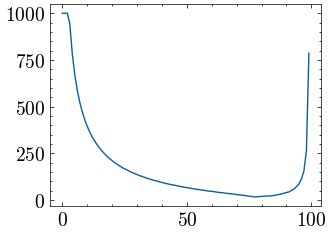

In [15]:
list1 = []
for i in np.linspace(0.01,1.99,100):
    list1.append(SOR(w=i)[1])
plt.plot(list1)
min_value = min(list1)
min_index = list1.index(min_value)
min_value,np.linspace(0.01,1.99,100)[min_index]

In [16]:
SOR(w=1.55)[1]

17

In [17]:
SOR(w=1.4)[1]

31

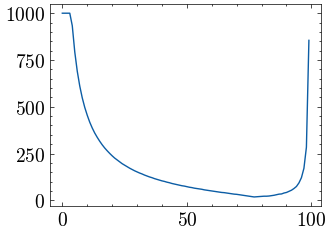

In [18]:
list2 = []
for i in np.linspace(0.01,1.99,100):
    list2.append(SSOR(w=i)[1])
plt.plot(list2)

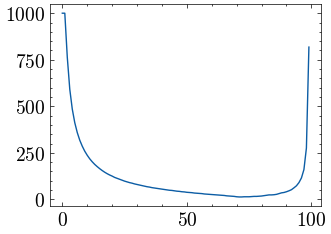

In [19]:
listBSOR = []
for i in np.linspace(0.01,1.99,100):
    listBSOR.append(BSOR(w=i)[1])
plt.plot(listBSOR)

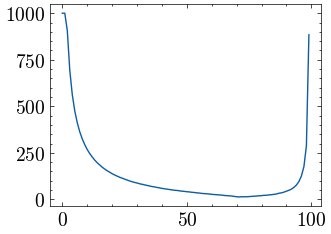

In [20]:
listBSSOR = []
for i in np.linspace(0.01,1.99,100):
    listBSSOR.append(BSSOR(w=i)[1])
plt.plot(listBSSOR)

In [21]:
min_value = min(list1)
min_index = list1.index(min_value)
min_value,np.linspace(0.01,1.99,100)[min_index]

(17, np.float64(1.55))

In [22]:
min_value = min(list2)
min_index = list2.index(min_value)
min_value,np.linspace(0.01,1.99,100)[min_index]

(18, np.float64(1.55))

In [23]:
min_value = min(listBSOR)
min_index = listBSOR.index(min_value)
min_value,np.linspace(0.01,1.99,100)[min_index]

(13, np.float64(1.43))

In [24]:
min_value = min(listBSSOR)
min_index = listBSSOR.index(min_value)
min_value,np.linspace(0.01,1.99,100)[min_index]

(13, np.float64(1.43))

In [25]:
u = CG()[0]
print(u)

[[0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.         0.02562343 0.0412507  0.05079571 0.05600214 0.05765604 0.05600214 0.05079571 0.0412507  0.02562343 0.        ]
 [0.         0.0412507  0.0685883  0.08592628 0.09554331 0.09862969 0.09554331 0.08592628 0.0685883  0.0412507  0.        ]
 [0.         0.05079571 0.08592628 0.10877765 0.12162233 0.12576653 0.12162233 0.10877765 0.08592628 0.05079571 0.        ]
 [0.         0.05600214 0.09554331 0.12162233 0.13641444 0.14119822 0.13641444 0.12162233 0.09554331 0.05600214 0.        ]
 [0.         0.05765604 0.09862969 0.12576653 0.14119822 0.1461922  0.14119822 0.12576653 0.09862969 0.05765604 0.        ]
 [0.         0.05600214 0.09554331 0.12162233 0.13641444 0.14119822 0.13641444 0.12162233 0.09554331 0.05600214 0.        ]
 [0.         0.05079571 0.08592628 0.10877765 0.12162233 0.12576653 0.12162233 0.10877765 0.08592628 0.05079571 0.        ]
 [0.    

  algorithm  iterations      time
0         J         121  0.031220
1        GS          68  0.017341
2       SOR          17  0.004874
3        BJ          69  0.014969
4       BGS          39  0.008423
5      BSOR          13  0.003185
6      SSOR          18  0.010428
7     BSSOR          13  0.006417
8        GD         108  0.035759
9        CG          11  0.004150


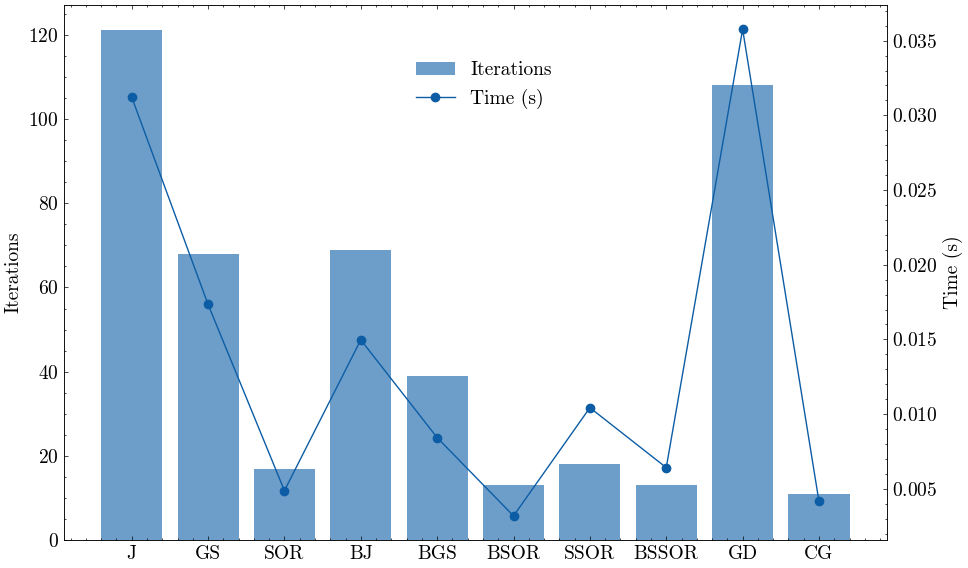

In [35]:
# 定义算法列表
algorithms = {
    "1": J,
    "2": GS,
    "3": SOR,
    "4": BJ,
    "5": BGS,
    "6": BSOR,
    "7": SSOR,
    "8": BSSOR,
    "9": GD,
    "10": CG,
}


choices = list(algorithms.keys())

plot = "y"

metrics = []  # 用于存储每个算法的性能指标

for choice in choices:
    choice = choice.strip()  # 去掉多余的空格
    if choice in algorithms:
        algorithm_function = algorithms[choice]

        # 多次执行算法并取平均时间
        repeat_count = 5  # 可设置为较高值，提升测量准确度
        total_time = 0.0
        for _ in range(repeat_count):
            # 记录开始时间
            start_time = time.perf_counter()
            
            u, k = algorithm_function()

            # 记录结束时间和单次时间
            end_time = time.perf_counter()
            total_time += end_time - start_time

        # 计算平均时间
        avg_time = total_time / repeat_count

        # 存储性能指标
        metrics.append(
            {
                "algorithm": algorithm_function.__name__,
                "iterations": k,
                "time": avg_time,
            }
        )
    else:
        print(f"无效的选择: {choice}")

print(pd.DataFrame(metrics))
if plot:
    # 提取数据用于绘图
    algorithms = [m["algorithm"] for m in metrics]
    iterations = [m["iterations"] for m in metrics]
    times = [m["time"] for m in metrics]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 绘制迭代次数柱状图
    ax1.bar(algorithms, iterations, alpha=0.6, label="Iterations")
    ax1.set_ylabel("Iterations")
    ax1.tick_params(axis="y")

    # 创建第二个y轴共享x轴，用于绘制时间数据
    ax2 = ax1.twinx()
    ax2.plot(algorithms, times, marker="o", label="Time (s)")
    ax2.set_ylabel("Time (s)")
    ax2.tick_params(axis="y")

    # 显示图例和标题
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.9))  
    # fig.suptitle("Algorithm Performance Comparison")
    fig.tight_layout()  # 调整布局避免重叠
    plt.show()
else:
    print("算法性能指标:", metrics)
    np.set_printoptions(linewidth=200)
    print(u)